# Notebook exercise 4

## 4.1

### Assignment

In Statistical Mechanics the Maxwell–Boltzmann distribution (<a href="https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution" target="_blank">Link Wikipedia</a>) is a probability distribution used for describing particle speeds in idealized gases. However, rarefied gases at ordinary temperatures behave very nearly like an ideal gas and the Maxwell–Boltzmann speed distribution is an excellent approximation for such gases. For a 3D system its formula is:
$$p(v,T) = \left( \frac{m}{2\pi k_B T} \right)^{3/2} 4\pi v^2 e^{-\frac{m v^2}{2 k_B T}}$$

By using LJ reduced units (Lenght: $\sigma$; Energy: $\epsilon$; Mass: the mass, $m$, of the particles; Temperature: $\epsilon/k_B$; velocity: $\sqrt{\epsilon/m}$) its form becomes:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$

The NSL_SIMULATOR code already computes the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$.

Include the calculation of the Maxwell–Boltzmann distribution, $p(v^*,T^*)$, inside your Molecular Dynamics code by using data blocking to obtain single block averages, progressive average values and progressive uncertainties for $p(v^*,T^*)$.

Remember that, the Maxwell–Boltzmann distribution, $p(v^*,T^*)$, can be approximately computed as a **normalized histogram** on an appropriate interval $\left[ 0, v_{max}\right]$ and chosing the number of bins into which you want to divide this interval.

### Solution

As mentioned in the assignment the given code is able to calculate the Internal energy, the potential energy, the kinetic energy, the temperature and the pressure. 

In order to evaluate the veocity distribution, I chose a $v_{max}$ value and a number of bins to divide the interval $\left[ 0, v_{max}\right]$. I used $v_{max} = 5 \sqrt{T}$ to count the most part of the particle's velocities, in fact the mean value of the Boltzmann distribution is given by $\langle v \rangle = 1.6 \sqrt{T} $ and $\sigma = \sqrt{(3 - 1.6^2) T}  \cong \frac{2}{3} \sqrt{T}$ so $5 \sqrt{T} > \langle v \rangle + 3 \sigma$. 

Given this two numbers, I estimate the velocity distribution counting the particles' velocities included in each subinterval of $\left[ 0, v_{max}\right]$. To normalize the distribution, I divide the counts by the number of particles and by the lenght of the subintervals, which is an estimate for the area of the distribution. Here, I report the implementation of this method: 
```c++
...
if(_measure_pofv){
    for(int i=0; i<_npart; i++){
        double v = pow(dot( _particle(i).getvelocity() , _particle(i).getvelocity()), 0.5);
        if(v < _bin_size_v * _n_bins_v){
        _measurement(_index_pofv + int(v/_bin_size_v))++;
        }else{
        _measurement(_index_pofv + _n_bins_v -1)++;
        }
    }
}
...
```

## 04.2

### Assignment

By means of your upgraded code, <span style="color:red">perform MD simulations via a Lennard-Jones model</span> ( e.g. Argon parameters: $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- gas phase: $\rho^\star = 0.05$, $T^\star \sim  2.0$ (cut-off radius: $r_c = 5.0$)

starting from a <span style="color:red">**very low entropic** initial configuration</span>:
1. initial **particle positions**: <span style="color:red">fcc crystal occupying half of the simulation box in each dimension</span>
2. initial **velocity distribution**: $p_\delta(v^*,T^*) = \delta\left( v^* - v_{T^*}\right)$ where $v_{T^*}$ is suitably connected to $T^*$. For example, this condition could be obtained by imposing that every particle has an initial velocity $\pm v_{T^*}$ for **only one** of its velocity components: $v_x$, $v_y$, $v_z$.

The goal is to show that, by evolving such initial condition via a Molecular Dynamics simulation, the velocity distribution tends to approximate the Maxwell–Boltzmann distribution.

- **Produce some pictures that show this convergence**
- The evolution of the system moves towards the increasing of entropy (more homeogeneous configuration of particles)? What would you find by changing the direction of time? Comment on these aspects in your jupyter-notebook

**Note that** the MD simulation will conserve the total energy; thus the kinetic energy and the temperature are not constant of motion ... the comparison should be done with $p(v^*,T^*_{\rm eff})$ where $T^*_{\rm eff}$ is the effective temperature obtained once the system has been equilibrated.

### Solution 



In the video below are rapresented the first step of the simulation. The video shows that the system rapidly evolves from the low-entropy configuration to a chaotic configuration. 

In [2]:
from IPython.display import HTML

HTML('''
<div style="text-align: center;">
    <img src="NSL_SIMULATOR/4.2.gif" width="500">
</div>
''')

To make this intuition more evident I rapresented the velocity distribution at different steps. The green and the blue lines represent the velocity distribution after $N_{step} = 2.5 * 10^3$ e $N_{step} = 10^4$. From this trend, we notice that the velocity distribution is initially substantially different from the Maxwell-Boltzmann (M-B), as expected for a low entropic configuration, however from the blue line we see that the system is evolving towards the M-B distibution. 

The pink line rapresent the velocity distribution after $N_{step} = 10^5$, which is quite similar to the the fitted Maxwell-Boltzmann distribution, showing the convergence of the system. It is is also interesting to note that the temperature obtained from the fit $T_{fit} = 2.18$ is very near the temperature of the system misurated by the code $T_{obs}$. 

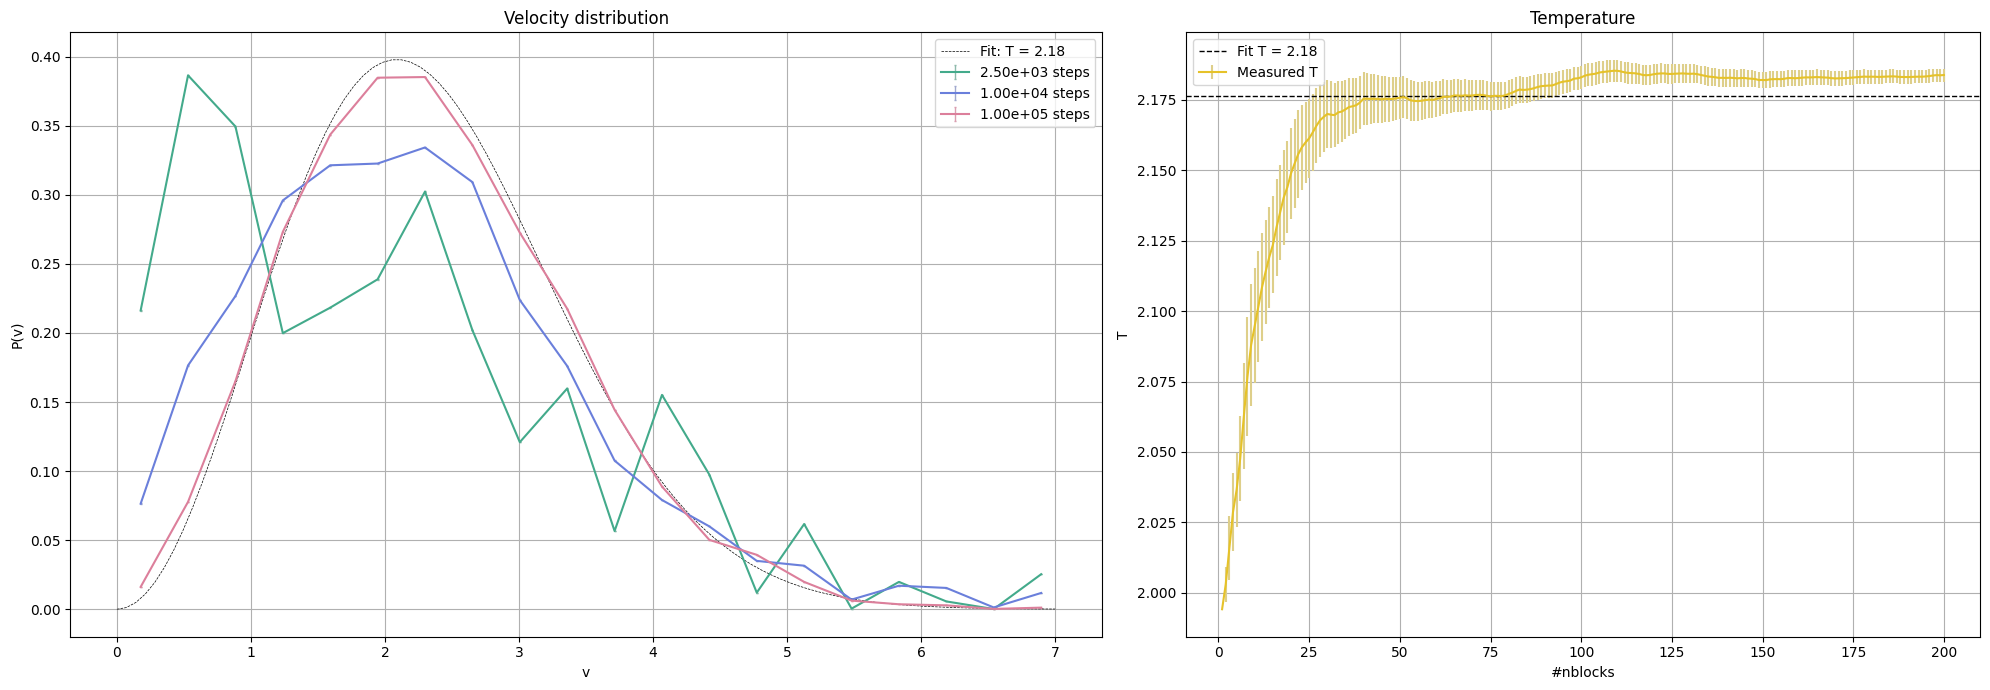

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
from scipy.optimize import curve_fit

def maxwell_boltzmann(v, T):
    coeff = 4 * np.pi / (2 * np.pi * T)**(3/2)
    return coeff * v**2 * np.exp(-v**2 / (2 * T))

#loading data for normal simulation
data = np.loadtxt("NSL_SIMULATOR/OUTPUT_4.2/pofv.dat")
Tem = np.loadtxt("NSL_SIMULATOR/OUTPUT_4.2/temperature.dat")
Pot = np.loadtxt("NSL_SIMULATOR/OUTPUT_4.2/potential_energy.dat")

# fitting data at 200 block n°200
mask = data[:, 0] == 200
v = data[mask, 1]          
pofv = data[mask, 3]        
err = data[mask, 4]      

# Fit the Maxwell-Boltzmann distribution to the data at 200 blocks
popt, pcov = curve_fit(maxwell_boltzmann, v, pofv, sigma=err, absolute_sigma=True, p0=[2.0])
T_fit = popt[0]
x = np.linspace(0, 7, 100)

fig, ax = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [1.3, 1]})

#plotting velocity distribution at different steps
ax[0].set_title('Velocity distribution')
ax[0].errorbar(data[data[:, 0] == 5, 1],data[data[:, 0] == 5, 3], color='#43AA8B',yerr=data[data[:, 0] == 5, 4]/108, 
        ecolor="#8EBAAC", elinewidth=1, capsize=1, label=f"{(5*500):.2e}"+" steps")
ax[0].errorbar(data[data[:, 0] == 20, 1], data[data[:, 0] == 20, 3], color='#6A7FDB', yerr=data[data[:, 0] == 20, 4]/108, 
        ecolor="#A1A9CE", elinewidth=1, capsize=1, label=f"{(20*500):.2e}"+" steps")
ax[0].errorbar(data[data[:, 0] ==200, 1], data[data[:, 0] == 200, 3], color='#DC7F9B',yerr=data[data[:, 0] == 200, 4]/108, 
        ecolor="#DA9FB1", elinewidth=1, capsize=1, label=f"{(200*500):.2e}"+" steps")
ax[0].plot(x, maxwell_boltzmann(x, T_fit), color='black', linestyle='--', linewidth=0.5, label=f'Fit: T = {T_fit:.2f}')
ax[0].set_xlabel('v')
ax[0].set_ylabel('P(v)')
ax[0].grid(True)
ax[0].legend()

#plotting temperature trend with fitted value 
ax[1].set_title('Temperature')
ax[1].errorbar(Tem[:, 0], Tem[:,2], yerr=Tem[:,3], color='#E6C229', ecolor="#DECF8A", elinewidth=1.5, capsize=0, label='Measured T')
ax[1].axhline(y=T_fit, color='black', linestyle='--', linewidth=1, label=f'Fit T = {T_fit:.2f}')
ax[1].set_xlabel('#nblocks')
ax[1].set_ylabel('T')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

##  04.3

### Assignment

Starting from the final state of an **equilibrated** MD simulation of the system in Exercise 04.2, by changing the direction of time (e.g. by inverting the final velocities, i.e. ... ), try to return back to the very low entropic initial configuration of Exercise 04.2. Is this possible? (for example, one can monitor the behavior of the average **potential energy** and the average **temperature** in **each block** as a function of time going **in both directions**). Show some picture and comment on what you find in your jupyter-notebook.

### Solution

The code uses the last two particles configurations to evaluate their velocities, so to change the direction of time I used the last two position configurations of the simulation for exercise 4.2 in reversed order. In this way, the velocities evaluated by the system with Verlet algorithm are inverted respect of the final velocities of the previous simulation.

Plotting the trends of the temperature and the potential energy of the system, we see that at first steps the system returns to the same point of the previos simulation, but after approximately 25 blocks the two profile are substantially different, so the system does not return back to the low-entropy configuration. 

This is due to the fact that the Verlet algorithm is time-reversible, so for the first step the system appear to move back to the initial configuration, but the Verlet predictions are approximated and after a large number of step this approximation becomes significant, leading the differences between the two trends. 

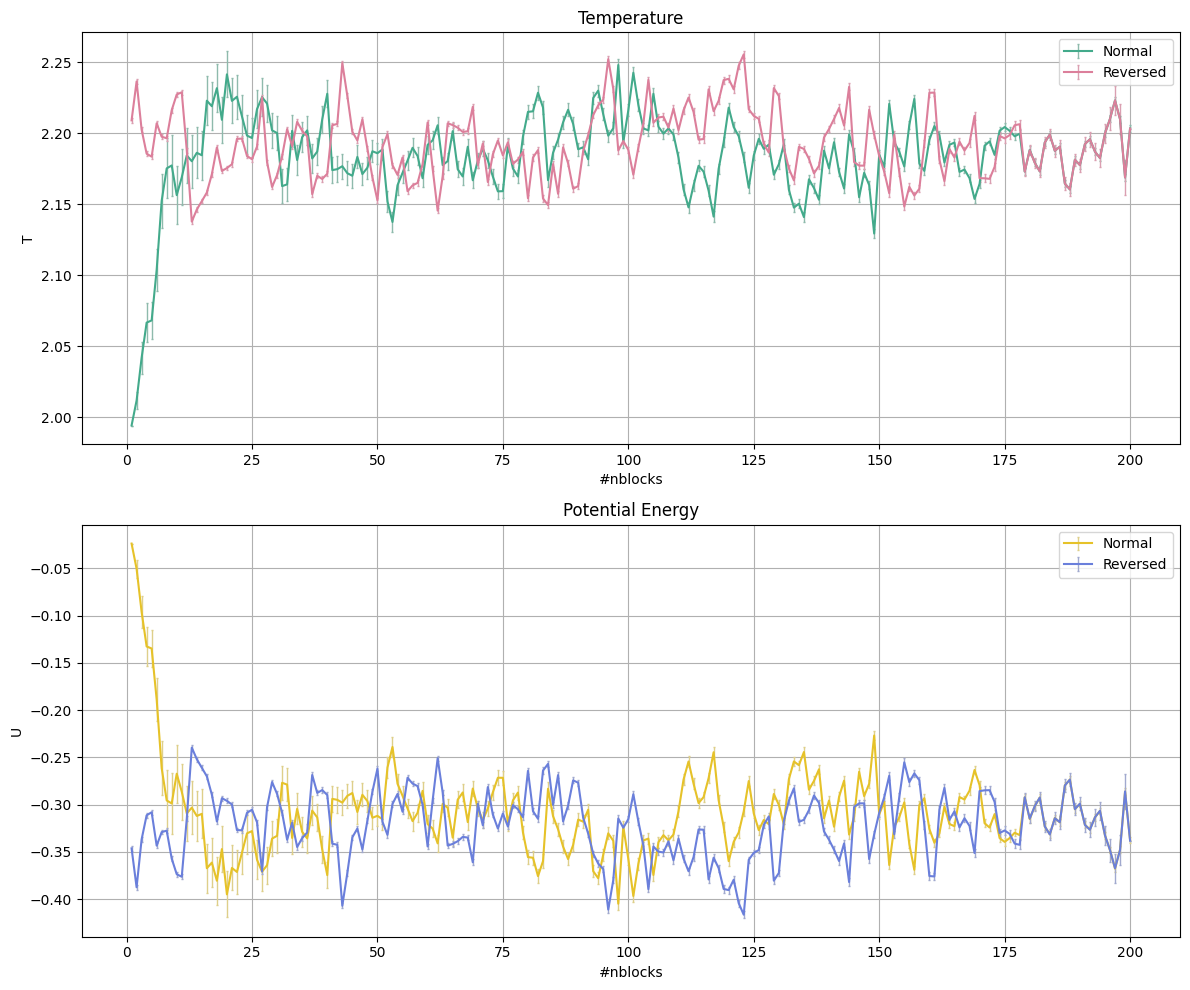

In [4]:
#loading data for reversed time simulation
Tem_rev = np.loadtxt("NSL_SIMULATOR/OUTPUT_rev/temperature.dat")
Pot_rev = np.loadtxt("NSL_SIMULATOR/OUTPUT_rev/potential_energy.dat")

fig, ax = plt.subplots(2,1, figsize=(12,10))

# plotting temperature trend
ax[0].set_title('Temperature')
ax[0].errorbar(Tem[:,0], Tem[:,1], yerr=Tem[:,3], color='#43AA8B', ecolor="#8EBAAC", elinewidth=1, capsize=1, label='Normal')
ax[0].errorbar(201-Tem_rev[:,0], Tem_rev[:,1], yerr=Tem_rev[:,3], color='#DC7F9B', ecolor="#DA9FB1", elinewidth=1, capsize=1, label='Reversed')
ax[0].set_xlabel('#nblocks')
ax[0].set_ylabel('T')
ax[0].grid(True)
ax[0].legend()

# plotting potential energy trend
ax[1].set_title('Potential Energy')
ax[1].errorbar(Pot[:,0], Pot[:,1], yerr=Pot[:,3], color='#E6C229', ecolor="#DECF8A", elinewidth=1, capsize=1, label='Normal')
ax[1].errorbar(201-Pot_rev[:,0], Pot_rev[:,1], yerr=Pot_rev[:,3], color='#6A7FDB', ecolor="#A1A9CE", elinewidth=1, capsize=1, label='Reversed')
ax[1].set_xlabel('#nblocks')
ax[1].set_ylabel('U')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()